<!--NOTEBOOK_HEADER-->
*This notebook contains material from [PyRosetta](https://RosettaCommons.github.io/PyRosetta.notebooks);
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).* This notebook was developed based on the original notebook by Thomas Guiziou (thomas.guiziou@vub.be).

# Design of de novo minibinder to the RBD of Sars-cov-2 
# RFdiffusion, ProteinMPNN, ColabFold 


## Design Project:
- The goal is to design a binder to the ACE2 receptor, that could act as a competitive inhibitor to the SARS-COV2 RBD (Receptor Binding Protein). 
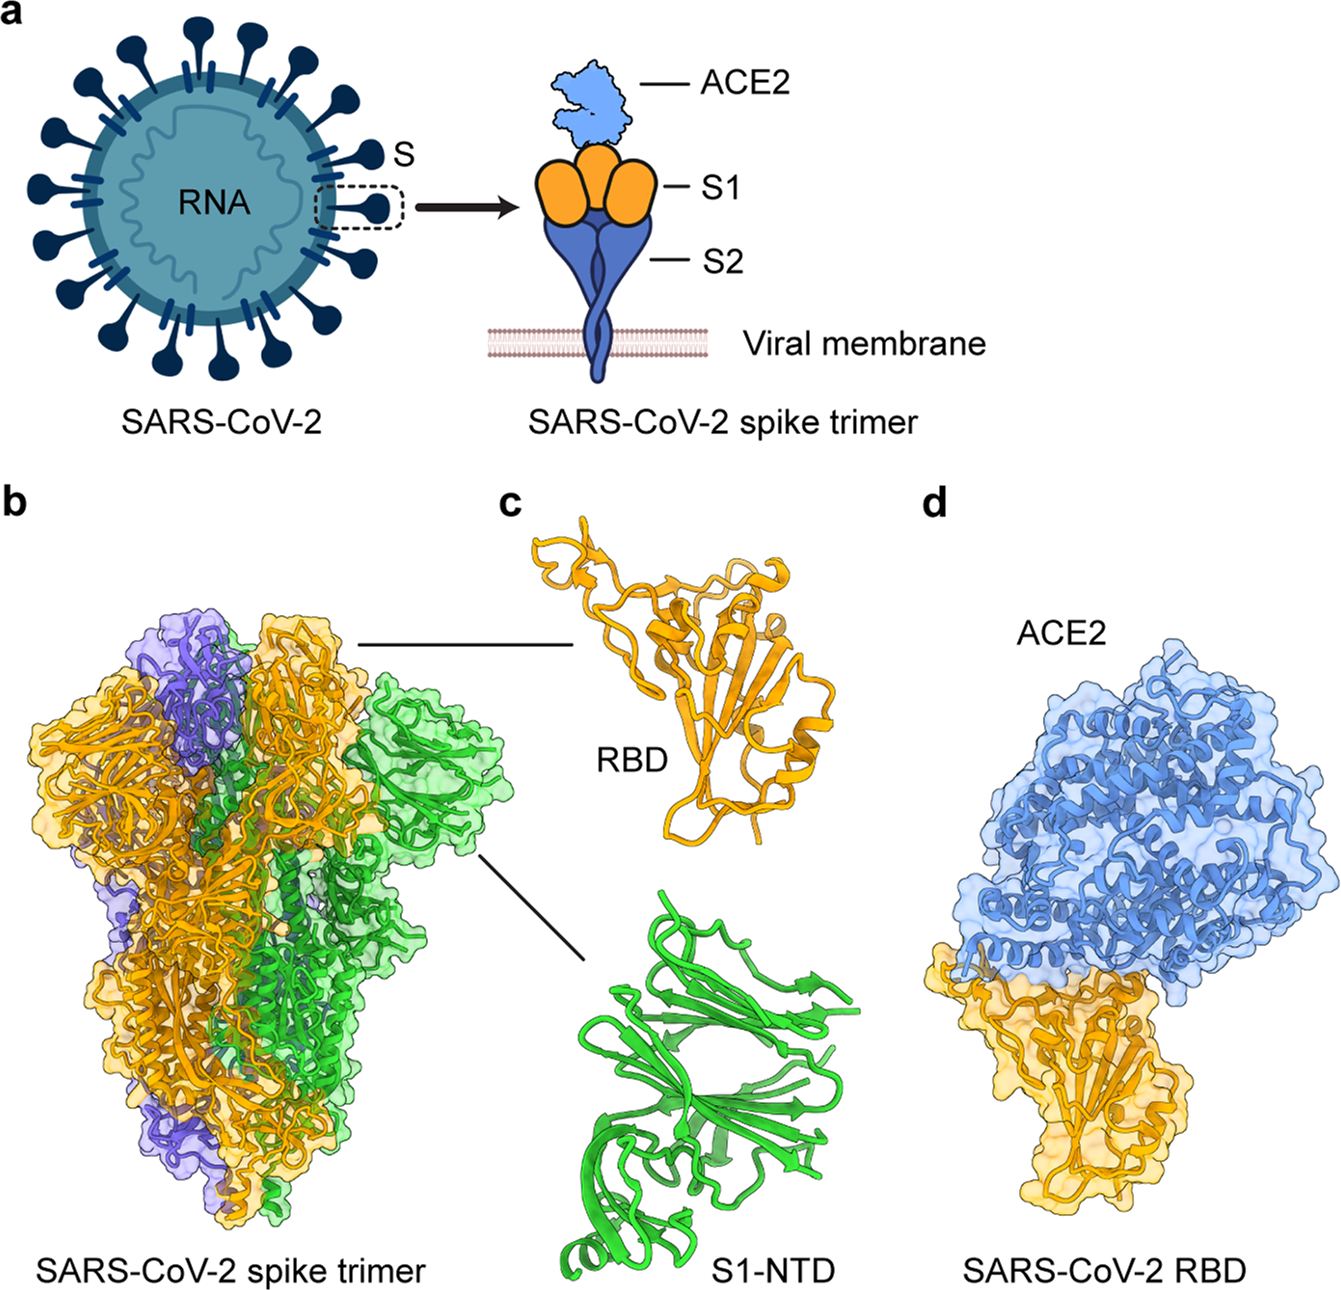
- Starting from the 7BH9 structure, we will use two strategies to design binders. We will design (i) a _de novo_ binder and (ii) we will strart from the RBD binding peptide and design a scaffold around it.
**De non designed interface**
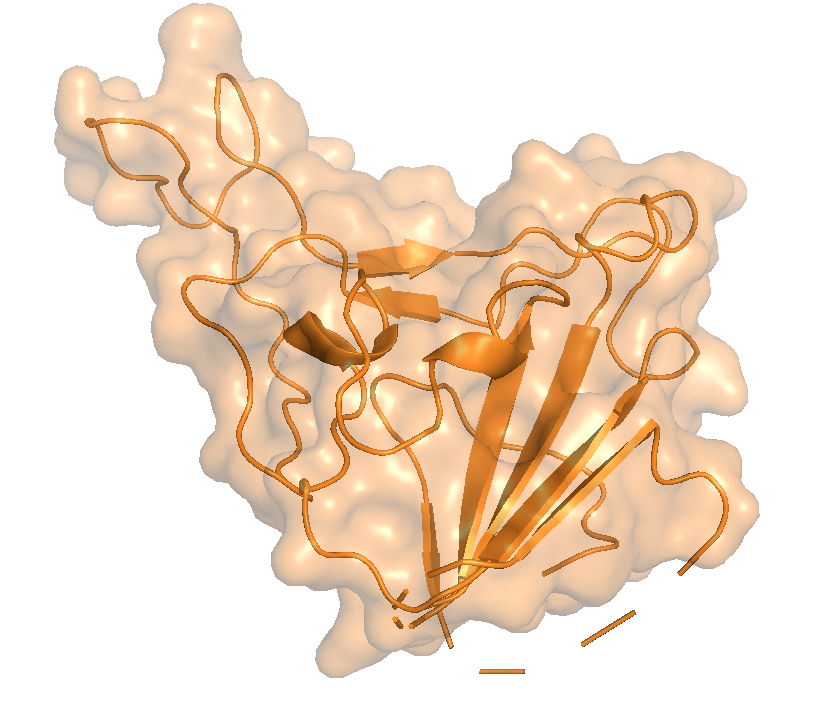
**Scaffolding the native binding motif in a smaller and better behaved protein**
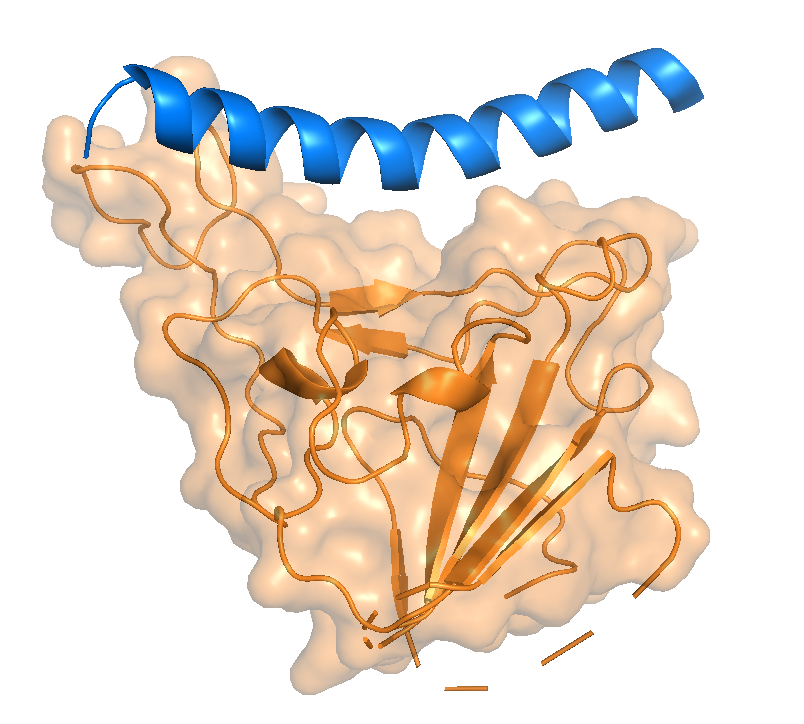

- The design pipeline starts with design of the backbones using **RFdiffusion**, then we design the sequence using **ProteinMPNN** and pick sequences using **ColabFold** with Initial Guess with single sequence mode. 

## Import modules and packages:

### <u>How to load a module</u> :
- Click on **Software** on the left tab, underneath the folder explorer
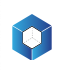
- Type the name of the packages and click on load
- Wait for the module to be load before loading another module 
    
The module are loaded for whole session of the notebook.  
After loading all of the module, to be able to import it you have to restart the ipikernel. You can click on:
- **Python 3 (ipykernel) | Idle** on the bottom left of the screen
- Choose the correct python environment : **Python 3 (ipykernel** 
- And press select 
    
### <u>Module to load by hand</u>
- matplotlib/3.5.2-foss-2022a
- Seaborn/0.12.1-foss-2022a
- Pyrosetta/4.release-384-gompi-2022a

# RFdiffusion

### The prompt for RFdiffusion:
- For the _de novo_ binder, we use the following prompt:  
run_inference.py inference.output_prefix={output_folder}/{output_prefix} \
    inference.input_pdb=input_RFdiffusion/7bh9_clean.pdb \
    inference.num_designs=1 \
    'contigmap.contigs=[E603-730/0 90-120]' \
    'ppi.hotspot_res=[E669,E671,E672,E689,E703,E705,E709,E712,E714,E716,E717,E718,E721]' \
    diffuser.T=25 "
- **inference.output_prefix**: the name of the designs.
- **inference.num_designs**: the number of trajectories to do.
- **inference.input_pdb**: the pdb of the protein we design the binder.
- **contigmap.contig**:
    - E603-730: the residues to be taken into account during the trajectory, they will be kept fixed ~RMSD <1 Å.
    - /0 : chain break.
    - 90-120 : RFdiffusion samples backbones from 90 residues to 120 residues randomly/
- **diffuser.T**: number of denoising step, other benchmark did not show any difference with more denoising steps. So 25 allows to reduce computing time. 
- **ppi.hotspot_res**: The residues the backbones should be close to. 

## Running RFdiffusion for the _de novo binder_ and the scaffold binder 

- Open a terminal 
- Go to the submit_scripts folder with:
    - cd submit_scripts 
    - cd = change directory 
- Load the RFdiffusion module with:
    - module load RFdiffusion/1.1.0-foss-2022a-CUDA-11.7.0
- Run the prompt with:
    - bash rf_diffusion_de_novo.sh 
    - Wait for it to finish 
    - bash rf_diffusion_scaffold.sh 
    - A folder is created in ProteinDesignWorkshop
- <u>**If it does not work**</u>:
    - Directory issue:
        - Use pwd (print working directory)
        - And navigate to the correct directory with cd, i.e. submit_scipts/
    - Issue with the modules:
        - Check the loaded module:
            - module list 
        - Unload the modules:
            - module purge 
        - Load the correct modules, see above 
- If needed, go back to the previous folder with:
    - cd ../
- Check which folder your notebook is in with:
    - os.getcwd()
    - os.chdir(your_directory)

## Picking backbone from Rfdiffusion runs:

- We use Pyrosetta to analyse the backbone produced using the following parameters:
    - number of helices > 2
    - loop percentage > 0.07
    - alpha percentage < 0.94
    - radius of gyration < 19 
    - number of helcies < 6

In [1]:
import glob
from copy import copy 
import json, warnings

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 

import pyrosetta as py
from pyrosetta import *

In [18]:
py.init('-mute all')
def create_movers():
    dssp_mover = py.rosetta.protocols.moves.DsspMover()
    interface_mover = py.rosetta.protocols.analysis.InterfaceAnalyzerMover("A_B")
    sf = py.ScoreFunction()
    score_type = py.rosetta.core.scoring.ScoreType(0).rg
    try:
        assert score_type.__str__()=="ScoreType.rg"
    except AssertionError:
        print("ScoreType is {score_type.__str__()} and not ScoreType.rg")  
    
    sf.set_weight(py.rosetta.core.scoring.ScoreType(326),1.0)
    ddg_mover = py.rosetta.protocols.ddg.ddGMover()
    return dssp_mover,sf,interface_mover, ddg_mover

def interface_analysis(pose,mover_interface):
    mover_interface.apply(pose)
    data = mover_interface.get_all_data()
    return data.dSASA, data.interface_nres, data.dG, data.centroid_dG

def annotate_ss(dssp):
    full_ss = {}
    nb_motif=1
    for i in range(0,len(dssp)):
        #     continue
        if i == 0:
            current_ss = {"motif":dssp[i], "start":i,"end":int, "length":int}

        if dssp[i] != dssp[i-1] and i != 0 :
            #change the sec struct writing 
            current_ss["end"] = i
            current_ss["length"] = current_ss["end"] -current_ss["start"] 
            full_ss[nb_motif] = copy(current_ss)
            nb_motif+=1
            current_ss = {"motif":dssp[i], "start":i,"end":int, "length":int}
        
        if i == len(dssp)-1:
            current_ss["end"] = i
            current_ss["length"] = current_ss["end"] -current_ss["start"] 
            full_ss[nb_motif] = copy(current_ss)
    return full_ss

def ss_content(dssp):
    beta_perc = dssp.count("E")/len(dssp)
    alpha_perc = dssp.count("H")/len(dssp)
    loop_perc = dssp.count("L")/len(dssp)
    # assert beta_perc+alpha_perc+loop_perc == 1
    return beta_perc, alpha_perc, loop_perc

def count_motif(dic, motif):
    count = 0 
    for i in dic.keys():
        if dic[i]["motif"] == motif:
            count += 1 
    return count

# try:
#     assert os.path.isdir(output_folder)
#     assert len(glob.glob(output_folder+"/*.pdb")) > 0
# except AssertionError: 
#     print("error with the output_folder:{output_folder}")

dssp_mover,sf_rg,interface_mover , ddg_mover = create_movers()
    # return dssp_mover,sf,interface_mover, ddg_mover
length_target_prot = 0

def create_dataset(folder):
    dataset = {}
    count = 0
    for path in glob.glob(f"{folder}/*.pdb"):
        pose = py.pose_from_pdb(path)
        length_designed_protein = pose.total_residue()-length_target_prot
        dssp_mover.apply(pose)
        annotated_ss = annotate_ss(pose.secstruct()[:length_designed_protein])
        nb_helices =  count_motif(annotated_ss,'H')
        dSASA, list_nres, dG, centroid_dG = interface_analysis(pose= pose, mover_interface=interface_mover)
        sf_rg.setup_for_scoring(pose)
        rg = sf_rg(pose)
        # datapoint = { "dSASA_total":dSASA[1], "dSASA_A":dSASA[2], "dSASA_B":dSASA[3], "interface_nres_total": list_nres[1], "interface_nres_A":list_nres[2], "interface_nres_B": list_nres[3], "length_designed":length_designed_protein, "nb_helice":nb_helices, "dG":dG[1], "centroid_dG":centroid_dG,"rg":rg}
        beta_perc,alpha_perc,loop_perc = ss_content(pose.secstruct()[:length_designed_protein])
        datapoint = {"length_designed":length_designed_protein, "nb_helice":nb_helices,"rg":rg, "beta_perc":beta_perc,"alpha_perc":alpha_perc, "loop_perc":loop_perc}
        name = path.split('/')[-1]
        dataset[name]=copy(datapoint)
        count +=1 
        if count in range(0,10000,10):
            print( f" ####### {count}/{len(glob.glob(f'{folder}/*.pdb'))} ####### ")
    fi = open(folder.replace("/","")+".json","w")
    json.dump(obj=dataset,fp=fi, indent=5)
    fi.close()
create_dataset("rfdiffusion_scaffold")
create_dataset("rfdiffusion_de_novo")

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python310.linux 2024.24+release.ca096dac4f43ee5ee195f87f3703a520fcf60cf9 2024-06-14T16:57:57] retrieved from: http://www.pyrosetta.org


Both design approaches generate similar number of alpha-helices (that is not specifid but generated spontaneously by the diffusion model.

<AxesSubplot:xlabel='nb_helice', ylabel='Count'>

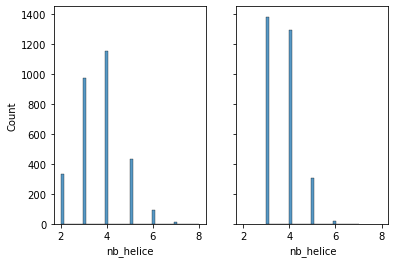

In [4]:
%matplotlib inline
df_denovo = pd.read_json(f"de_novo_precomputed/analysis_bb_denovo.json").T
df_scaffold = pd.read_json(f"scaffold_precomputed/scaffold_bb_analysis.json").T
fig, (ax1,ax2) = plt.subplots(sharex=True, sharey=True, nrows=1,ncols=2)
sns.histplot(data=df_denovo, x='nb_helice',ax=ax1)
sns.histplot(data=df_scaffold, x="nb_helice", ax=ax2)

Let's now look at the radius of giration of the designs. The motif scaffolding approach generates on average, more homogenous designs but de novo design makes more compact models.

<AxesSubplot:xlabel='rg', ylabel='Count'>

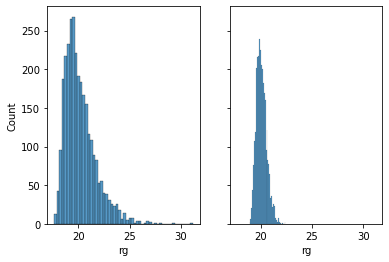

In [5]:
fig, (ax1,ax2) = plt.subplots(sharex=True, sharey=True, nrows=1,ncols=2)
sns.histplot(data=df_denovo, x='rg',ax=ax1)
sns.histplot(data=df_scaffold, x="rg", ax=ax2)

Let's look at the secondary structure content of the designs. RFDiffusion tends to generate mostly alpha-helical proteins if secondary structure content is not enforced.

<AxesSubplot:xlabel='beta_perc', ylabel='Count'>

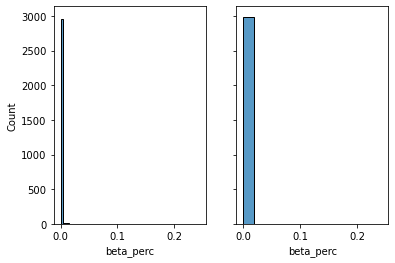

In [6]:
fig,(ax1,ax2) = plt.subplots(sharex=True, sharey=True, nrows=1,ncols=2)
sns.histplot(data=df_denovo, x='beta_perc',ax=ax1)
sns.histplot(data=df_scaffold, x="beta_perc", ax=ax2)



<AxesSubplot:xlabel='alpha_perc', ylabel='Count'>

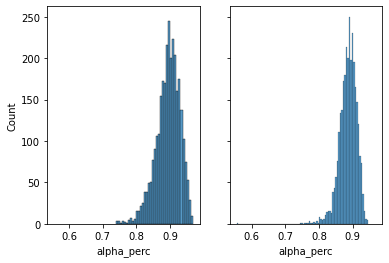

In [7]:
fig,(ax1,ax2) = plt.subplots(sharex=True, sharey=True, nrows=1,ncols=2)
sns.histplot(data=df_denovo,x="alpha_perc",ax=ax1)
sns.histplot(data=df_scaffold,x="alpha_perc",ax=ax2)

<AxesSubplot:xlabel='loop_perc', ylabel='Count'>

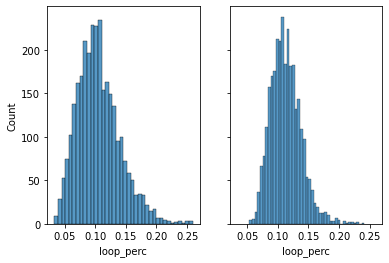

In [8]:
fig,(ax1,ax2) = plt.subplots(sharex=True, sharey=True, nrows=1,ncols=2)
sns.histplot(data=df_denovo,x="loop_perc",ax=ax1)
sns.histplot(data=df_scaffold,x="loop_perc",ax=ax2)

Based on these distributions, we will pick the best designs in the cell below. See that around 500 out of 2000 models pass the selection criteria in the pre-computed designs. 

Try to replace the pre-computed data with the models you just generated. That is easy, just replace in the cell above:
- "de_novo_precomputed/analysis_bb_denovo.json" with "rfdiffusion_de_novo.json" 
- "scaffold_precomputed/scaffold_bb_analysis.json" wih "rfdiffusion_scaffold.json"

Are there good designs? Please remember that, to generate good designs, thousands of models must be generated. Don't get discouraged if 5 models is not enough to get good results.

In [9]:
picked_denovo_bb = df_denovo.loc[(df_denovo["nb_helice"]>2)&(df_denovo["loop_perc"]>0.07)&(df_denovo["alpha_perc"]<0.94)&(df_denovo["rg"]<19)&(df_denovo["nb_helice"]<6)]
print(picked_denovo_bb.shape)
picked_scaffold_bb =  df_scaffold.loc[(df_scaffold["nb_helice"]>2)&(df_scaffold["loop_perc"]>0.05)&(df_scaffold["alpha_perc"]<0.94)&(df_scaffold["rg"]<19.6)&(df_scaffold["nb_helice"]<6)]
print(picked_scaffold_bb.shape)


(583, 6)
(503, 6)


In [12]:
import shutil

In [19]:
folder_picked_bb = "de_novo_precomputed/picked_denovo_bb"
if not os.path.isdir(folder_picked_bb ):
    os.mkdir(folder_picked_bb )
    
for path_bb in picked_denovo_bb.index:
    shutil.copy('de_novo_precomputed/' + "prod_bb_denovo/"+path_bb, folder_picked_bb+"/")

folder_picked_bb = "scaffold_precomputed/picked_scaffold_bb"

if not os.path.isdir(folder_picked_bb ):
    os.mkdir(folder_picked_bb )
print(picked_scaffold_bb.index)
for path_bb in picked_scaffold_bb.index:
    shutil.copy('scaffold_precomputed/prod_bb_scaffold/'+path_bb, folder_picked_bb+"/")


Index(['scaffold_152.pdb', 'scaffold_283.pdb', 'scaffold_2273.pdb',
       'scaffold_1073.pdb', 'scaffold_2853.pdb', 'scaffold_1532.pdb',
       'scaffold_2264.pdb', 'scaffold_182.pdb', 'scaffold_217.pdb',
       'scaffold_1764.pdb',
       ...
       'scaffold_1064.pdb', 'scaffold_150.pdb', 'scaffold_333.pdb',
       'scaffold_507.pdb', 'scaffold_2523.pdb', 'scaffold_627.pdb',
       'scaffold_1318.pdb', 'scaffold_1681.pdb', 'scaffold_24.pdb',
       'scaffold_2270.pdb'],
      dtype='object', length=503)


# Running ProteinMPNN

### After we picked the RFdiffusion backbones we design the sequences using ProteinMPNN:
- ProteinMPNN requires helper scripts to work, at minimum parse_multiple_chains.py and in our case we add assign_fixed_chains.py to design only the chain designed by RFdiffusion, i.e. chain A
- Other ProteinMPNN parameters are:
    - num_seq_per_target
    - sampling_temp: increases the diversity of sequence produced
    - it is also possible to change the weights of ProteinMPNN for specific tasks 

## To run ProteinMPNN 
- Open a terminal 
- Go to the submit_scripts folder with:
    - cd submit_scripts 
    - cd = change directory 
- Load the RFdiffusion module with:
    - module load ProteinMPNN/1.0.1-20230627-foss-2022a-CUDA-11.7.0
- Run the prompt with:
    - bash protein_mpnn_denovo.sh
    - Wait for it to finish 
    - bash protein_mpnn_scaffold.sh
    - A folder is created in ProteinDesignWorkshop
- <u>**If it does not work**</u>:
    - Directory issue:
        - Use pwd (print working directory)
        - And navigate to the correct directory with cd, i.e. submit_scipts/
    - Issue with the modules:
        - Check the loaded module:
            - module list 
        - Unload the modules:
            - module purge 
        - Load the correct modules, see above 
- If needed, go back to the previous folder with:
    - cd ../

In [20]:
py.init("-mute all")



def get_seq_target(path):
    pose = py.pose_from_pdb(path)
    c_selector = py.rosetta.core.select.residue_selector.ChainSelector("A")
    return pose.sequence()[len(list(c_selector.selection_positions(pose))):]

def make_fasta(fasta_folder,bb_folder,fasta_name):
    to_write=[]
    seq_target = get_seq_target(glob.glob(f"{bb_folder}/*.pdb")[0])
    # print(fasta_folder)
    for seq in glob.glob(fasta_folder+"/*.fa"):
        with open(seq) as fi:
            lines = fi.readlines()
        name = seq.split("/")[-1].replace(".fa","")
        count = 1
        for i in range(0,len(lines)):
            if lines[i].startswith(">T"):
                to_write.append(f">{name}_{count}")
                to_write.append(lines[i+1].replace("\n","")+":"+ seq_target)
                count+=1
    print(to_write)
    with open(fasta_name,'w') as fi:
        for line in to_write:
            fi.writelines(line+"\n")

            
make_fasta("mpnn_denovo/seqs", "rfdiffusion_de_novo", "de_novo.fa")
make_fasta("mpnn_scaffold/seqs", "rfdiffusion_scaffold", "scaffold.fa")
print("done")

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python310.linux 2024.24+release.ca096dac4f43ee5ee195f87f3703a520fcf60cf9 2024-06-14T16:57:57] retrieved from: http://www.pyrosetta.org
['>de_novo_0_1', 'AEEEEERRRREEERAAREAEERAKKRKERKKKRKELAKKYMKDIKKLEKKRKKKKKRKKKYSKLLKRTKKLKKKKEKKKLKKKLKPLIKKLKKLLKKKKKKLKEKKKKLK:ASFSTFKCYYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDF

## Running colabfold 

Now that we have designed sequences, let's verify again if these sequences are compatible with the expected structures. To do so, we will predict structures for the generated sequences using colabFold and some tricks from the de novo design community.

### <u>Initial Guess</u>:
- We already know the structure of the ACE2 binding domain, so we can give that structural information to ColabFold so the network will focus on the designed chain.
- Thus we provide the .cif of the template with modifications from https://github.com/sokrypton/ColabFold/issues/177
- Designed sequence will be new to nature, thus the MSA will not provide information. We use the single sequence mode to do the prediction without MSA 
- Then the designed sequences are picked using:
    - pLDDT > 90
    - RMSD between the design model and the ColabFold model < 1
    - pAE < 6
    - manual inspection of the ColabFold model     
    
Code modified from https://github.com/sokrypton/ColabFold

## To Run ColabFold 
    - Change directory to submit_scripts 
    - Load ColabFold/1.5.2-foss-2022a-CUDA-11.7.0:
        module load ColabFold/1.5.2-foss-2022a-CUDA-11.7.0
    - bash colabfold_denovo.sh
    - bash colabfold_scaffold.sh

## Analyze ColabFold results:

In [22]:
def load_cbatch_results(dir_res):
    dict = {}
    if os.path.exists(dir_res.replace("/",".json")):
        fi = open(dir_res.replace("/",".json"),"r")
        df =  pd.DataFrame(json.load(fi))
        fi.close()
        return df

    for res in glob.glob(dir_res+"*_scores_*.json"):
        with open(res,"r") as fi:
            data = json.load(fi)
            mean_plddt = sum(data["plddt"]) / len(data["plddt"])
            mean_pae_res = []
            for i in data["pae"]:
                mean_pae_res.append(sum(i)/len(i))
            dict[res.split("/")[-1]] = {"mean_plddt":mean_plddt, "ptm":data["ptm"], "pae":sum(mean_pae_res)/len(mean_pae_res)}
    df = pd.DataFrame(dict).T
    
    df.to_json(path_or_buf=dir_res.replace("/",".json"))
        
    return df


def load_tmalign_res(path_json):
    with open(path_json,'r') as j:
        dict = json.load(j)
        foo_df = pd.DataFrame(dict).T
        new_index=[]
        for index in foo_df.index:
            new_index.append(index.split("/")[-1].replace("unrelaxed","scores").replace(".pdb",".json"))
        foo_df.index = new_index
        return foo_df

def json_to_pdb(json_path):
    return json_path.replace("scores","unrelaxed").replace("json","pdb")


# os.system("python run_tmalign_workshop.py picked_bb/ output_cfold/ tmalign_cfold.json")
# df_tmalign = load_tmalign_res("tmalign_cfold.json")

# df_cfold = pd.concat([load_cbatch_results("output_cfold/"), load_tmalign_res("tmalign_cfold.json")], axis=1)


Let's take a look at how the different metrics look like for the models that were pre-computed. 

In [23]:
df_scaffold = pd.concat([pd.read_json("scaffold_precomputed/cfold_scaffold.json"), load_tmalign_res("scaffold_precomputed/tmalign_scaffold.json")],axis=1)
df_denovo = pd.concat([pd.read_json("de_novo_precomputed/cfold_initial_guess_prod.json"), load_tmalign_res("de_novo_precomputed/cfold_initial_guess_prod_tmalign.json")],axis=1)
df_scaffold.dropna(inplace=True)
df_denovo.dropna(inplace=True)
print(df_scaffold.shape)
print(df_denovo.shape)

(25150, 5)
(29150, 5)


Let's look at the distributions of prediction confidence attributed to the models by colabfold. Usually, we would aim for models that have a pLDDT confidcence score about 90%.

<AxesSubplot:xlabel='mean_plddt', ylabel='Count'>

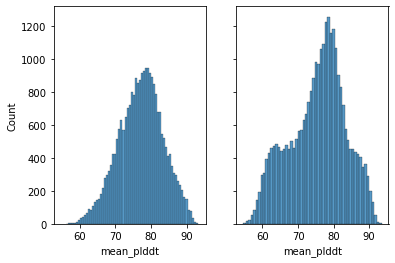

In [24]:
%matplotlib inline
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True)
sns.histplot(data=df_scaffold, x="mean_plddt", ax=ax1)
sns.histplot(data=df_denovo, x="mean_plddt", ax=ax2)


pAE is a protein-protein interaction prediction metric. It predicts the confidence of the interface (how confident are we that protein A does not move or shift relative to protein B? pAE should be as small as possible.

<AxesSubplot:xlabel='pae', ylabel='Count'>

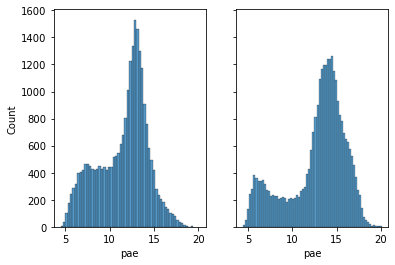

In [26]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True)
sns.histplot(data=df_scaffold, x="pae", ax=ax1)
sns.histplot(data=df_denovo, x="pae", ax=ax2)

Finally, let's check the accuracy of the prediction How similar is the prediction structure to the expected design model? Here, we are hoping to find design with Root Mean Square Deviation less than 2 A. 

<AxesSubplot:xlabel='RMSD', ylabel='Count'>

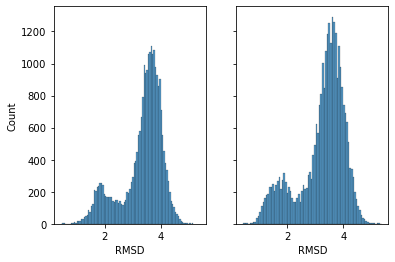

In [27]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True)
sns.histplot(data=df_scaffold, x="RMSD", ax=ax1)
sns.histplot(data=df_denovo, x="RMSD", ax=ax2)

In [ ]:
picked_denovo = de_denovo.loc[(de_denovo["RMSD"]<1)&(de_denovo["mean_plddt"]>90)&(de_denovo["pae"]<5)]
# picked_scaffold = Your turn to choose